# Machine Learning Part I

## 1. Introduction

### 1.1 What is Machine Learning?

[Machine learning](https://en.wikipedia.org/wiki/Machine_learning) was described by Arthur Samuel as the "field of study that gives computers the ability to learn without being explicitly programmed".  Machine learning is particularly used when the following three principles apply:

1. a pattern exists
2. the pattern cannot be "pinned down" mathematically
3. we have data on that pattern

### 1.2 How much data do we need in order to learn?

Two related concepts can give us insight as to why we are able to learn from data.

#### 1.2.1 Hoeffding's Inequality

For a bin of size $N$, the probability relating the sample frequency, $\nu$, and the bin frequency, $\mu$ is given by [Hoeffding's Inequality](https://en.wikipedia.org/wiki/Hoeffding%27s_inequality):

$$\mathbb{P} \left[ \left| \nu - \mu \right| > \epsilon \right] \le 2e^{-2\epsilon^2 N}$$

It is valid for all $N$ and $\epsilon$ and the bound does not depend on $\mu$.  It illustrates the tradeoff between $N$, $\epsilon$, and the bound.

#### 1.2.2 The Law of Large Numbers

The following is the weak [law of large numbers](https://en.wikipedia.org/wiki/Law_of_large_numbers):

$$\lim_{m\rightarrow\infty} \mathbb{P} \left[ \left| \underset{X \sim P}{\mathbb{E}}[\mathbf{X}] - \frac{1}{m}\sum\limits_{i=1}^m x_i \right| > \epsilon \right] = 0$$

**Further Reading**:

1. [Machine Learning Theory - Part 1: Introduction](https://mostafa-samir.github.io/ml-theory-pt1/) | Mostafa Samir
2. [Machine Learning Theory - Part 2: Generalization Bounds](https://mostafa-samir.github.io/ml-theory-pt2/) | Mostafa Samir

Later, we will observe how increasing sample size improves our ability to learn

### 1.3 Libraries used in this exercise

In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
import itertools
np.set_printoptions(precision=4)
#np.set_printoptions(edgeitems=3,infstr='inf',linewidth=75,nanstr='nan',precision=8,suppress=False,threshold=1000,formatter=None)
%matplotlib inline

## 2. Machine Learning Example

### 2.1 Learning Boolean Target Function

In this example, we intend to "learn" a Boolean target function.  The function takes in input vector of size 3, say [0, 1, 0] or [0, 1, 1] and outputs a single output, $y_n$, which can be zero or 1.  If we enumerate the set of all possible target functions, we would have $2^{2^3}$ distinct Boolean functions on 3 Boolean inputs.

In this example, we wish to score 4 different hypotheses, $g_a, g_b, g_c, g_d$ based on how well they perform on "out of sample points".  The scoring system is 1 point per correct point, i.e. if the function gets 3 "out of sample points" correct, it will get a score of 3.  We wish to calcuate the total score when enumerating over the entire set of all possible functions.

Code is as follows:

In [2]:
def calculate_score_last3(y,g):
    total_score=0
    for y_last in y[:,5:]:
        total_score += np.sum(y_last==g)
    return total_score

In [3]:
g_a = np.vstack(np.array([1,1,1,1,1]))
g_b = np.vstack(np.array([0,0,0,0,0]))
g_c = np.vstack(np.array([0,1,1,0,1]))
g_d = np.logical_not(g_a).astype(int)
y = np.array(list(itertools.product([0,1],repeat=8)))

print("Scores:\n(a) {}\n(b) {}\n(c) {}\n(d) {}".format(
    calculate_score_last3(y,[1,1,1]),
    calculate_score_last3(y,[0,0,0]),
    calculate_score_last3(y,[0,0,1]),
    calculate_score_last3(y,[1,1,0])))

Scores:
(a) 384
(b) 384
(c) 384
(d) 384


## 3. The Perceptron

### 3.1 Introduction & Background

The [Perceptron](https://en.wikipedia.org/wiki/Perceptron) is attributed to the work of Frank Rosenblatt in 1957.  It is a binary classifier that works on the basis of whether a dot product, $\mathbf{w \cdot x}$, exceeds a certain threshold:

$$f(\mathbf{x}) = \left\{ \begin{array}{cl} 1, & \text{if } \mathbf{w \cdot x} > 0\\0, & \text{otherwise}
\end{array}\right.$$

This can be written in the form of a hypothesis given by:

$$h(\mathbf{x}) = \text{sign}(\mathbf{w^T x}) = \text{sign}\left(\sum_{i=1}^N w_i x_i\right)$$

### 3.2 Generating Sample Data

The following code generates a three-column random matrix with the first column as ones.

In [4]:
def generate_data(n,seed=None):
    if seed is not None:
        np.random.seed(seed)
    x0 = np.ones(n)
    x1 = np.random.uniform(low=-1,high=1,size=n)
    x2 = np.random.uniform(low=-1,high=1,size=n)
    return np.vstack((x0,x1,x2)).T

### 3.3 Creating a random line inside the region of interest

The region of interest is $\mathcal{X}=\left[-1,1\right] \times \left[-1,1\right]$,
where $\times$ denotes the [Cartesian Product](https://en.wikipedia.org/wiki/Cartesian_product).

To ensure that the random line falls within the region of interest, two points, $(x_0,y_0)$ and $(x_1,y_1)$ are generated within $\mathcal{X}$.

#### 3.3.1 Equation of the random line in the slope-intercept form, $y = mx + c$

$$\text{Slope, }m = \frac{y_1 - y_0}{x_1 - x_0}$$

$$\text{Intercept, }c = y_0 - m x_0$$

#### 3.3.2 Equation of the random line in hypothesis [weights] form

The hypothesis, in the two dimensional case ($N=2$), and since $x_0=1$:

$$h(\mathbf{x}) = \text{sign}(w_0 + w_1 x_1 + w_2 x_2)$$

The decision boundary, $h(\mathbf{x})=0$ is given by:

$$w_0 + w_1 x_1 + w_2 x_2 = 0$$

This can be converted to the slope-intercept form if we take $x_1$ to be the $x$ axis, and $x_2$ to be the $y$ axis, i.e.:

$$w_0 + w_1 x + w_2 y = 0$$

$$y = - \frac{w_1}{w_2} x - \frac{w_0}{w_2}$$

Comparison with the equation $y = mx + c$ yields the following relationships:

$$m = - \frac{w_1}{w_2}$$

$$c = - \frac{w_0}{w_2}$$

If we arbitrarily set $w_2=1$, we arrive at the following set of weights, which is consistent with the decision boundary denoted by $y = mx + c$:

$$\mathbf{w} = \left(-c,-m,1\right)$$

In [5]:
def get_random_line(seed=None):
    X = generate_data(2,seed=seed)
    x = X[:,1]
    y = X[:,2]
    m = (y[1]-y[0])/(x[1]-x[0])
    c = y[0] - m*x[0]
    w = np.array([-c,-m,1])
    return w

def draw_random_line(ax,w,marker='g--'):
    m = -w[1]/w[2]
    c = -w[0]/w[2]
    x = np.linspace(-1,1,20)
    y = m*x + c
    ax.plot(x,y,marker)
    
def get_hypothesis(X,w):
    h=np.dot(X,w)
    return np.sign(h).astype(int)

### 3.4 Generating a Training Dataset

The following code generates a training dataset and plots it

In [6]:
def plot_data(fig,plot_id,X,y=None,w_arr=None,my_x=None,title=None):
    ax = fig.add_subplot(plot_id)
    if y is None:
        ax.plot(X,y,'gx')
    else:
        ax.plot(X[y > 0,1],X[y > 0,2],'b+',label='Positive (+)')
        ax.plot(X[y < 0,1],X[y < 0,2],'ro',label='Negative (-)')
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.grid()
    ax.legend(loc='best',frameon=True)
    if w_arr is not None:
        if isinstance(w_arr,list) is not True:
            w_arr=[w_arr]
        for i,w in enumerate(w_arr):
            if i==0:
                draw_random_line(ax,w,'g-')
            else:
                draw_random_line(ax,w,'g--')
    if my_x is not None:
        ax.plot([my_x[0]],[my_x[1]],'kx',markersize=10)
    if title is not None:
        ax.set_title(title)

In [7]:
def create_dataset(N,make_plot=True,seed=None):
    X = generate_data(N,seed=seed)
    w_theoretical = get_random_line()
    y = get_hypothesis(X,w_theoretical)
    if make_plot is True:
        fig = plt.figure(figsize=(7,5))
        plot_data(fig,111,X,y,w_theoretical,title="Initial Dataset")
    return(X,y,w_theoretical)

### 3.5 The Perceptron Learning Algorithm

The Preceptron Learning Algorithm (PLA) is implemented in the following steps

1. Calculate $h\left(\mathbf{x}\right)=\text{sign}\left(\mathbf{w^T x}\right)$ which can take on values of -1, 0, or 1 for each sample.
2. Compare $h\left(\mathbf{x}\right)$ with $y$ to find misclassified point(s) if any.
3. Pick one misclassified point at random.
4. Iterate the weights according to the PLA: $w = w + y_n x_n$, where $y_n$ is the correct classification for the misclassified point, and $x_n$ is the misclassified point.

In [8]:
def PLA(w,X,y0,n_iterations=10,verbose=True):
    assert len(y0)==X.shape[0]
    n=len(y0)
    x_arr = list()
    w_arr = list()
    m_arr = list()
    for i in range(n_iterations):
        h   = get_hypothesis(X,w)
        bad = h != y0
        bad = np.argwhere(bad).flatten()
        if len(bad) > 0:
            idx  = np.random.choice(bad,1)[0]
            my_x = X[idx,:]
            m_arr.append(100.0*len(bad)/n)
            x_arr.append(my_x)
            w_arr.append(np.copy(w))
            w += np.dot(y0[idx],my_x)
            if verbose is True:
                print("iter {}: {}% misclassified, w={}" \
                      .format(i,m_arr[-1],w_arr[-1]))
        else:
            m_arr.append(0.0)
            x_arr.append(np.array([1.0, np.nan,np.nan]))
            w_arr.append(np.copy(w))
            if verbose is True:
                print("iter {}: zero misclassified (PLA has converged)".format(i))
            return w,w_arr,m_arr,x_arr
    print("PLA failed to converge after {} iterations".format(i))
    return None,None,None,None

### 3.6 Implementing the PLA

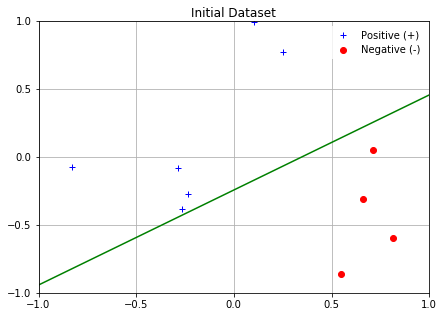

In [9]:
X,y,w_theoretical = create_dataset(N=10,make_plot=True,seed=247)
w0 = np.array([0,0,0],dtype=float)

In [10]:
w,w_arr,m_arr,x_arr = PLA(w0,X,y,n_iterations=100,verbose=True)

iter 0: 100.0% misclassified, w=[ 0.  0.  0.]
iter 1: 40.0% misclassified, w=[ 1.     -0.2676 -0.3799]
iter 2: 10.0% misclassified, w=[ 0.     -1.0827  0.2181]
iter 3: 20.0% misclassified, w=[ 1.     -0.83    0.9908]
iter 4: 20.0% misclassified, w=[ 0.     -1.4921  1.3024]
iter 5: zero misclassified (PLA has converged)


w_arr[1] = [ 1.     -0.2676 -0.3799], x_arr[1] = [ 0.8151 -0.598 ]
w_arr[2] = [ 0.     -1.0827  0.2181], x_arr[2] = [ 0.2527  0.7728]
w_arr[3] = [ 1.     -0.83    0.9908], x_arr[3] = [ 0.6621 -0.3116]
w_arr[4] = [ 0.     -1.4921  1.3024], x_arr[4] = [-0.2676 -0.3799]
w_arr[5] = [ 1.     -1.7598  0.9225], x_arr[5] = [ nan  nan]


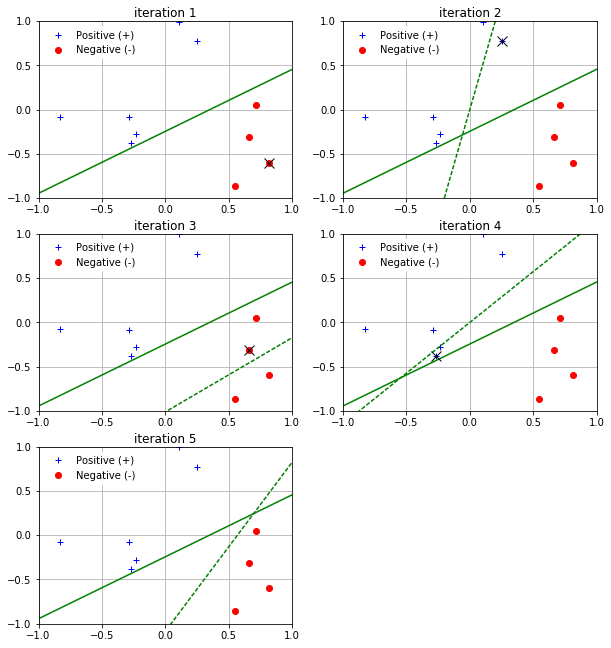

In [11]:
def draw_plot_steps(fig,plot_id,X,y,w_theoretical,w_arr,x_arr,idx_arr):
    assert len(idx_arr) <= 9
    for idx in idx_arr:
        print("w_arr[{}] = {}, x_arr[{}] = {}".format(idx,w_arr[idx],idx,x_arr[idx][1:]))
        plot_data(fig,plot_id,X,y,[w_theoretical] + [w_arr[idx]],
                  x_arr[idx][1:],title="iteration {}".format(idx))
        plot_id += 1

fig = plt.figure(figsize=(10,15))
draw_plot_steps(fig,421,X,y,w_theoretical,w_arr,x_arr,np.arange(len(w_arr)-1)+1)

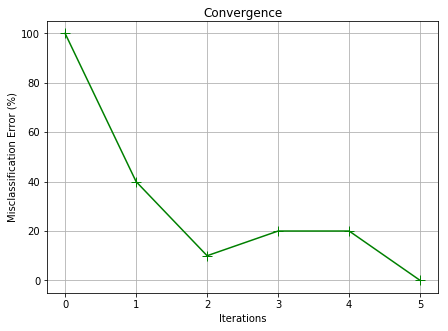

In [12]:
def plot_convergence(m_arr):
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot(111)
    ax.plot(m_arr,'g+-',markersize=10)
    ax.grid(True)
    ax.set_title("Convergence")
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Misclassification Error (%)")
plot_convergence(m_arr)

### 3.7 Number of iterations required for convergence

In [13]:
def plot_histogram(my_count,bins=200,x_max=80):
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot(111)
    ax.hist(my_count,bins=bins);
    ax.set_xlim(0,x_max)
    ax.grid(True)
    
def get_iteration_distribution(N,n_trials=1000,max_iterations=10000,summary=True):
    n_iterations=np.zeros(n_trials,dtype=int)
    w0 = np.array([0,0,0],dtype=float)
    for i in range(n_trials):
        X,y,w_theoretical = create_dataset(N=N,make_plot=False,seed=None)
        w,w_arr,m_arr,x_arr = PLA(w0,X,y,n_iterations=max_iterations,verbose=False)
        n_iterations[i]=len(w_arr)
        
    if summary is True:
        print("Minumum iterations: {}".format(np.min(n_iterations)))
        print("Maximum iterations: {}".format(np.max(n_iterations)))
        print("Mean    iterations: {}".format(np.mean(n_iterations)))
    return n_iterations

Minumum iterations: 1
Maximum iterations: 240
Mean    iterations: 9.006


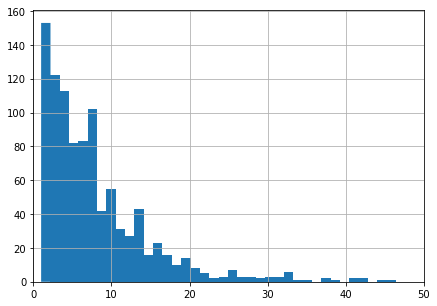

In [14]:
n_iterations = get_iteration_distribution(N=10,n_trials=1000)
plot_histogram(n_iterations,bins=200,x_max=50)

### 3.8 Calculate the misclassification error for the converged weights

Here, we calculate the number of points misclassified by `w` (after convergence).  The variable `w_theoretical` is used to obtain the correct classifications for the points.

In [15]:
def calculate_misclassification(w_theoretical,w,n_samples=1000,verbose=True):
    X  = generate_data(n_samples,seed=None)
    y0 = get_hypothesis(X,w_theoretical)
    y  = get_hypothesis(X,w)
    n_correct = np.sum(y == y0)
    if verbose is True:
        if w_theoretical[0] != 0.0:
            print("Theoretical Weights  : {}".format(w_theoretical/w_theoretical[0]))
        else:
            print("Theoretical Weights  : {}".format(w_theoretical))
        print("PLA Predicted Weights: {}".format(w))
        print("Correct points   = {}".format(n_correct))
        print("Incorrect points = {}".format(n_samples-n_correct))
        print("Misclassification= {}%".format(np.round(100 * (n_samples-n_correct)/n_samples, 4)))
        fig = plt.figure(figsize=(7,5))
        plot_data(fig,111,X,y0,[w_theoretical,w])
    return (n_samples-n_correct)/n_samples

Theoretical Weights  : [ 1.     -2.8719  4.1079]
PLA Predicted Weights: [ 1.     -1.7598  0.9225]
Correct points   = 825
Incorrect points = 175
Misclassification= 17.5%


0.17499999999999999

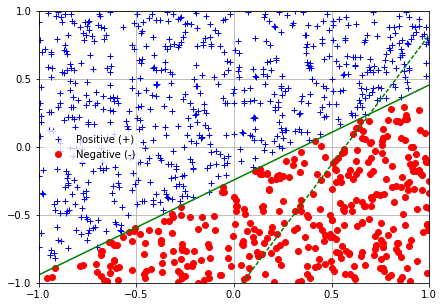

In [16]:
misclassification = calculate_misclassification(w_theoretical,w,verbose=True)
misclassification

In [17]:
def plot_misclassification(my_count,bins=20,x_max=0.25):
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot(111)
    ax.hist(my_count,bins=bins);
    ax.set_xlim(0,x_max)
    ax.grid(True)

In [18]:
def get_misclassification_distribution(N=10,n_trials=1000,max_iterations=10000,summary=True):
    w0 = np.array([0,0,0],dtype=float)
    misclassification=np.zeros(n_trials)
    for i in range(n_trials):
        X,y,w_theoretical = create_dataset(N,make_plot=False,seed=None)
        w,w_arr,m_arr,x_arr = PLA(w0,X,y,n_iterations=max_iterations,verbose=False)
        misclassification[i]=calculate_misclassification(w_theoretical,w,n_samples=1000,verbose=False)
        
    if summary is True:
        print("Minumum misclassification: {}".format(np.min(misclassification)))
        print("Maximum misclassification: {}".format(np.max(misclassification)))
        print("Mean    misclassification: {}".format(np.mean(misclassification)))
    return misclassification

### 3.9 Iteration distribution and misclassification distribution for N=10

Minumum iterations: 1
Maximum iterations: 265
Mean    iterations: 9.471


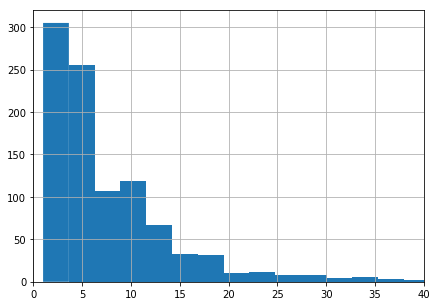

In [19]:
n_iterations = get_iteration_distribution(N=10,n_trials=1000)
plot_histogram(n_iterations,bins=100,x_max=40)

Minumum misclassification: 0.002
Maximum misclassification: 0.474
Mean    misclassification: 0.108496


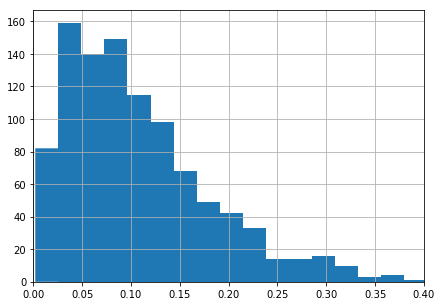

In [20]:
misclassification = get_misclassification_distribution(N=10)
plot_misclassification(misclassification,bins=20,x_max=0.4)

### 3.10 Iteration distribution and misclassification distribution for N=100

Minumum iterations: 1
Maximum iterations: 6713
Mean    iterations: 81.904


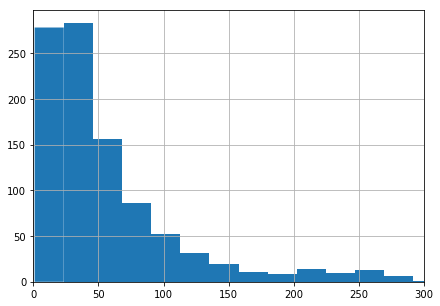

In [21]:
n_iterations = get_iteration_distribution(N=100,n_trials=1000)
plot_histogram(n_iterations,bins=300,x_max=300)

Minumum misclassification: 0.0
Maximum misclassification: 0.075
Mean    misclassification: 0.014019000000000002


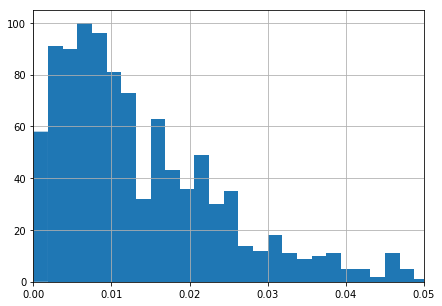

In [22]:
misclassification = get_misclassification_distribution(N=100)
plot_misclassification(misclassification,bins=40,x_max=0.05)

### 3.11 Convergence Plot for N=100

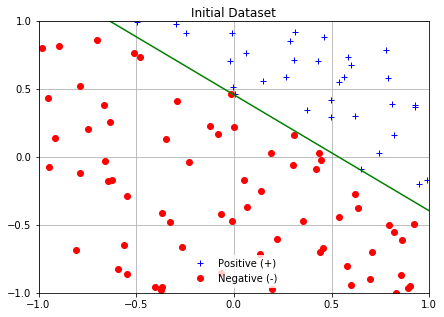

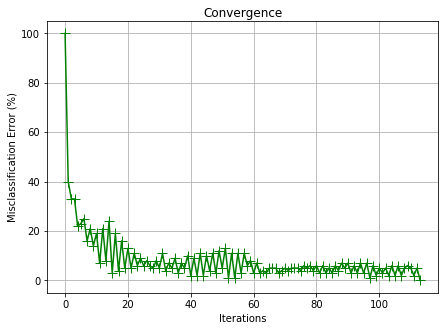

In [23]:
X,y,w_theoretical = create_dataset(N=100,make_plot=True,seed=12345)
w0 = np.array([0,0,0],dtype=float)
w,w_arr,m_arr,x_arr = PLA(w0,X,y,n_iterations=1000,verbose=False)
plot_convergence(m_arr)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in double_scalars


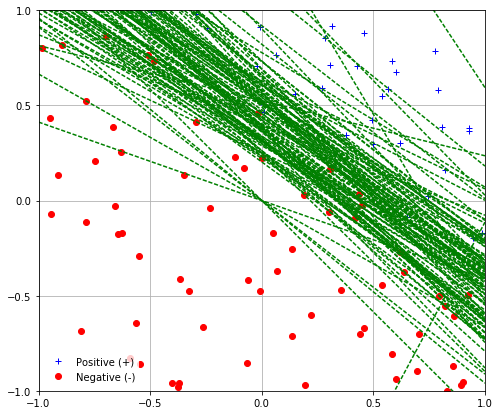

In [24]:
fig = plt.figure(figsize=(8,7))
plot_data(fig,111,X,y,[w_theoretical] + w_arr)